## Keras approach 2

### Importing libraries and data

In [1]:
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd 
import seaborn as sns


# Keras
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from keras.layers import Embedding,Dense,Dropout,GRU, LSTM
from keras.models import Sequential
import keras.backend as K
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
# Train-Test
from sklearn.model_selection import train_test_split
# Scaling data
from sklearn.preprocessing import StandardScaler
# Classification Report
from sklearn.metrics import classification_report

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
combined = pd.read_csv('cleaned_data_150k.csv')

In [4]:
combined.head()

,text,target
0,An image forming apparatus of the present inve...,0
1,"However, in the conventional aerial vehicle de...",2
2,The first aspect of a method for recovering a ...,1
3,"First Aspect of Invention', 'The present inven...",0
4,"As described above, according to the cap, the ...",1


### Prepare input data

In [5]:
y = combined["target"]

In [6]:
y_cat = to_categorical(y)

In [7]:
texts = combined.text.values

In [8]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(texts)

In [9]:
max_len = 512

In [10]:
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences, maxlen=512)

In [11]:
data.shape

(150000, 512)

In [12]:
from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,y_cat,test_size=0.2,random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5,random_state=101)


In [13]:
print(len(X_train))
print(len(X_test))
print(len(X_val))


120000
15000
15000


In [14]:
word_index = tokenizer.word_index

In [15]:
GLOVE_FILE = 'glove.6B.100d.txt'
f = open(GLOVE_FILE,'r',encoding="utf8")


In [16]:
embeddings_index = {}
import numpy as np
for line in f:
  values = line.split()
  word = values[0]
  embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()

In [17]:
embedding_matrix = np.random.random((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Normal model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 100)         9186700   
                                                                 
 lstm_3 (LSTM)               (None, 128)               117248    
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)               

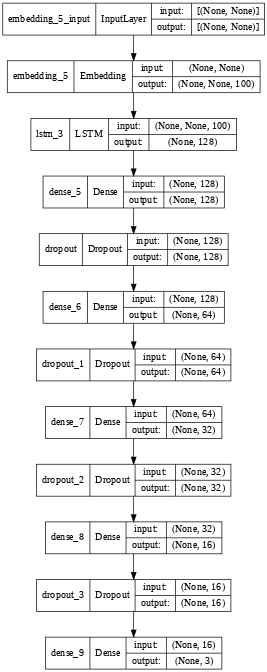

In [ ]:

# from keras.optimizers import Adam

model = Sequential()

model.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix],trainable=False))

model.add(LSTM(units=128,dropout = 0.5,recurrent_dropout = 0.2))

model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=64,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=32,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=16,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3,activation="softmax"))
# output model skeleton
opt = Adam(learning_rate = 0.005)
model.summary()
model.compile(optimizer= opt , loss ='categorical_crossentropy',metrics=['accuracy'])
plot_model(model, to_file='/content/drive/MyDrive/dataset_patent/figures/dl_model_anno_50.png', show_shapes=True, show_layer_names=True, dpi=50)


In [ ]:
model.fit(X_train, y_train, verbose=1, epochs=2)

Epoch 1/2
   6/4219 [..............................] - ETA: 3:53:09 - loss: 1.1080 - accuracy: 0.3229

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(X_test, y_test)

469/469 [==============================] - 70s 149ms/step - loss: 0.2251 - accuracy: 0.9330


[0.2250736653804779, 0.9330000281333923]

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(y_pred.shape)
print(y_test.shape)

(15000, 3)
(15000, 3)


In [ ]:
y_pred = (y_pred > 0.5)

In [ ]:
y_pred[0]

array([False,  True, False])

In [ ]:
print((classification_report(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      5026
           1       0.94      0.92      0.93      4980
           2       0.93      0.95      0.94      4994

   micro avg       0.94      0.93      0.93     15000
   macro avg       0.94      0.93      0.93     15000
weighted avg       0.94      0.93      0.93     15000
 samples avg       0.93      0.93      0.93     15000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Sequential model LSTM

#### Without using glove embeddings

In [18]:
len(word_index)

91866

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 100)          9186700   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 9,229,135
Trainable params: 9,229,135
Non-trainable params: 0
_________________________________________________________________


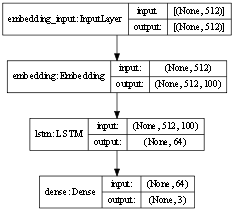

In [19]:
model1 = Sequential()
# model1.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix]))
model1.add(layers.Embedding(len(word_index)+1, 100, input_length=max_len))
# model1.add(Embedding(max_words, 20))
model1.add(LSTM(64,dropout=0.5))
model1.add(Dense(3,activation='softmax'))

model1.summary()
model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
# checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
plot_model(model1, to_file='dl_model_lstm_wo_anno_400.png', show_shapes=True, show_layer_names=True, dpi=400)
plot_model(model1, to_file='dl_model_lstm_wo_anno_50.png', show_shapes=True, show_layer_names=True, dpi=50)

In [20]:
# history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])
history_1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=10)

Epoch 1/10
3750/3750 [==============================] - 106s 28ms/step - loss: 0.3171 - accuracy: 0.8993 - val_loss: 0.1928 - val_accuracy: 0.9400
Epoch 2/10
3750/3750 [==============================] - 103s 28ms/step - loss: 0.1870 - accuracy: 0.9402 - val_loss: 0.1408 - val_accuracy: 0.9567
Epoch 3/10
3750/3750 [==============================] - 103s 28ms/step - loss: 0.1397 - accuracy: 0.9559 - val_loss: 0.1162 - val_accuracy: 0.965047s - loss: 0.1466 -  - ETA: 40s  - ETA: 38s - loss: 0.1456 - accu - ETA: 35s - loss: 0.143 - ETA: 33s - loss: 0.1437 - accuracy: 0. - ETA: 33s - loss: 0.1435 - a - ETA:
Epoch 4/10
3750/3750 [==============================] - 104s 28ms/step - loss: 0.1150 - accuracy: 0.9636 - val_loss: 0.1018 - val_accuracy: 0.9674A: 53s - loss: 0.1174 - accuracy - ETA: 53s - loss: 0.1173 - accuracy: 0. - ETA: 52
Epoch 5/10
3750/3750 [==============================] - 103s 28ms/step - loss: 0.1025 - accuracy: 0.9675 - val_loss: 0.0916 - val_accuracy: 0.970646s - loss: 0.

In [21]:
a = len(history_1.history["loss"])

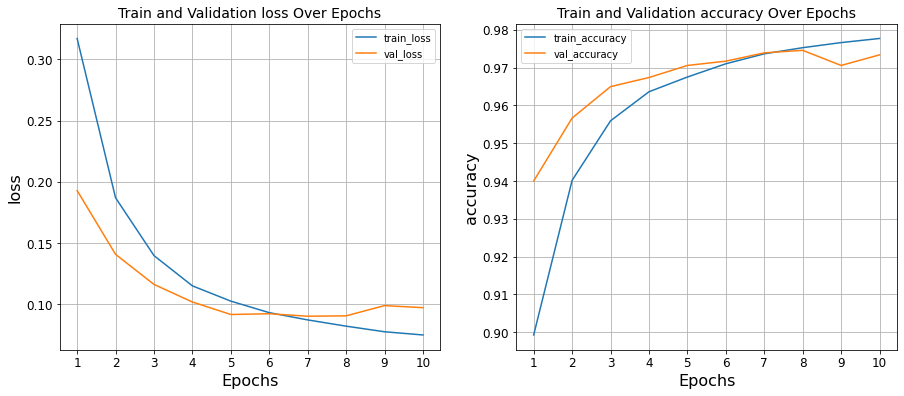

In [22]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_1.history["loss"], label="train_loss")
plt.plot(history_1.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_1.history["accuracy"], label="train_accuracy")
plt.plot(history_1.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_lstm_wo_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_lstm_wo_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [23]:
model1.evaluate(X_test, y_test)

469/469 [==============================] - 5s 10ms/step - loss: 0.0982 - accuracy: 0.9727


[0.098218634724617, 0.9726666808128357]

In [24]:
y_pred_1 = model1.predict(X_test)

In [25]:
y_pred_1 = (y_pred_1 > 0.5)

In [26]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      4969
           1       0.98      0.96      0.97      5002
           2       0.97      0.98      0.98      5029

   micro avg       0.97      0.97      0.97     15000
   macro avg       0.97      0.97      0.97     15000
weighted avg       0.97      0.97      0.97     15000
 samples avg       0.97      0.97      0.97     15000



C:\Users\tschi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
print(len(word_index))

91866


In [28]:
print()

#### With the glove embeddings

In [29]:
len(word_index)

91866

In [30]:
model1 = Sequential()
model1.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
# model1.add(layers.Embedding(len(word_index)+1, 100, input_length=max_len))
# model1.add(Embedding(max_words, 20))
model1.add(LSTM(64,dropout=0.5))
model1.add(Dense(3,activation='softmax'))

model1.summary()
model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
# checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
#plot_model(model1, to_file='dl_model_lstm_w_anno_400.png', show_shapes=True, show_layer_names=True, dpi=400)
#plot_model(model1, to_file='dl_model_lstm_w_anno_50.png', show_shapes=True, show_layer_names=True, dpi=50)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 512, 100)          9186700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 9,229,135
Trainable params: 42,435
Non-trainable params: 9,186,700
_________________________________________________________________


In [31]:
# history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])
history_1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=10)

Epoch 1/10
3750/3750 [==============================] - 85s 22ms/step - loss: 0.4224 - accuracy: 0.8364 - val_loss: 0.1848 - val_accuracy: 0.93731:00 - lo - ETA: 58s - loss: 0.7026 - accurac - ETA: 57s - loss: 0.6 - ETA: 56s - loss: 0.6845 - accur - ETA: 55s - loss: 0.6782 - accuracy: 0.709 - ETA: 55s -  - ETA: 53s - loss: 0.6605 - accurac - ETA: 53s - loss: 0.6556 - accuracy: 0.722 - ETA: 53s - loss: 0.6550 - - ETA: 52s - loss: 0.6462 - accuracy: 0.72 - ETA: 52s - loss: 0.6455 - accu - ETA: 51s - loss: 0. - ETA: 49s - loss: 0.6268 - ETA: 48s - loss: 0.6176 - - ETA: 44s - loss: 0.5918 - accuracy: 0. - ETA - ETA: 42s - loss: 0.5738 - accuracy:  - ETA: 41s - loss: 0.5715 - accuracy: 0.76 - ETA: 41s - loss: 0.5 - ETA - ETA: 32s - loss: 0.5254 - accuracy:  - ET - ETA: 29s  - ETA: 27s - loss: 0.5045 - accuracy: 0.798 - ETA: 27s - loss: 0.5044  - ETA: 23s - loss: 0. - ETA: 21 - ETA: 19s - loss: 0.4764 - accuracy: - ETA: 19s - loss: 0.4749 - accur - ETA: 7s - loss: - ETA: 6s - loss: 0.4376 - 

3750/3750 [==============================] - 86s 23ms/step - loss: 0.1066 - accuracy: 0.9647 - val_loss: 0.0907 - val_accuracy: 0.9716 ETA: 1:14 - loss: 0.1010 - accuracy:  - ETA: 1:14 - loss: 0.1020 - accuracy: 0. - ETA - ETA: 1:09 - loss: 0.1 - ETA: 1:09 - loss: 0.1023 - accuracy: 0. - ETA: 1:03 - l - ETA: 1:00 - l - ETA: 1:00 - l - ETA: 58s - loss: 0.1034 - accuracy: 0.9 - ETA: 58s - lo - ETA: 56s - loss: 0.1 - ETA: 54s - loss: 0.1037 - accuracy: 0.965 - ETA: 54s - loss: - ETA: 50s - loss: 0.1060 - accuracy: 0.965 - ETA: 50s - loss: 0.1060 - accuracy: 0.965 - ETA: 50s - lo - ETA: 48s - loss: 0.1069 - accuracy: - ETA: 47s - loss: 0.1066 - accuracy: 0.965 - ETA: 47s - loss: 0.1066 - accura - ETA: 47s - loss: 0.1071 -  - ETA: 46s - loss: 0.1067 - acc - ETA: 45s - loss: 0.1075 - accuracy: - ETA: 4 - ETA: 42s - loss: 0.1071 - accuracy: 0. - ETA: 42s - loss: 0.1074 - - ETA: 41s - loss: 0.1075 - accuracy: 0.9 - ETA: 41s - loss: 0.1076 - ac  - ETA: 37s - loss: 0.1069 - accur - ETA: 37s - ET

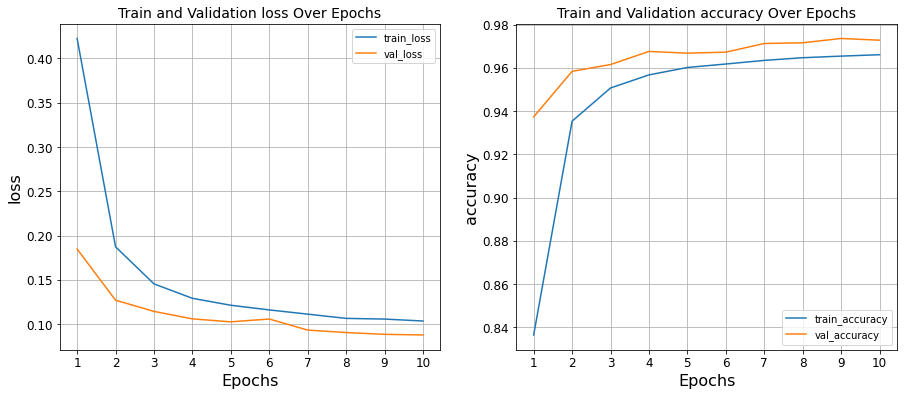

In [32]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_1.history["loss"], label="train_loss")
plt.plot(history_1.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1),fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_1.history["accuracy"], label="train_accuracy")
plt.plot(history_1.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_lstm_w_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_lstm_w_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [33]:
model1.evaluate(X_test, y_test)

469/469 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.97 - 5s 10ms/step - loss: 0.0886 - accuracy: 0.9723


[0.08859343826770782, 0.9723333120346069]

In [34]:
y_pred_1 = model1.predict(X_test)

In [35]:
y_pred_1 = (y_pred_1 > 0.5)

In [36]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      4969
           1       0.97      0.97      0.97      5002
           2       0.98      0.97      0.97      5029

   micro avg       0.97      0.97      0.97     15000
   macro avg       0.97      0.97      0.97     15000
weighted avg       0.97      0.97      0.97     15000
 samples avg       0.97      0.97      0.97     15000



C:\Users\tschi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
print(len(word_index))

91866


In [38]:
print()

### Sequential model Bi-LSTM

#### Withouht glove embeddings

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 512, 100)          9186700   
_________________________________________________________________
bidirectional (Bidirectional (None, 20)                8880      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 63        
Total params: 9,195,643
Trainable params: 9,195,643
Non-trainable params: 0
_________________________________________________________________


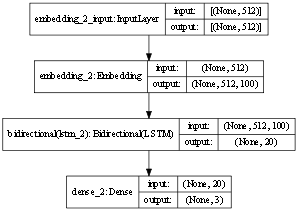

In [39]:
model2 = Sequential()
model2.add(layers.Embedding(len(word_index)+1, 100, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(10,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()
plot_model(model2, to_file='dl_model_bilstm_wo_anno_400.png', show_shapes=True, show_layer_names=True, dpi=400)
plot_model(model2, to_file='dl_model_bilstm_wo_anno_50.png', show_shapes=True, show_layer_names=True, dpi=50)


In [40]:
history_2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=10)

Epoch 1/10
3750/3750 [==============================] - 163s 43ms/step - loss: 0.3999 - accuracy: 0.8490 - val_loss: 0.2509 - val_accuracy: 0.9241
Epoch 2/10
3750/3750 [==============================] - 160s 43ms/step - loss: 0.2125 - accuracy: 0.9359 - val_loss: 0.1642 - val_accuracy: 0.9526
Epoch 3/10
3750/3750 [==============================] - 160s 43ms/step - loss: 0.1621 - accuracy: 0.9512 - val_loss: 0.1605 - val_accuracy: 0.9550
Epoch 4/10
3750/3750 [==============================] - 163s 43ms/step - loss: 0.1421 - accuracy: 0.9570 - val_loss: 0.1474 - val_accuracy: 0.9563
Epoch 5/10
3750/3750 [==============================] - 161s 43ms/step - loss: 0.1259 - accuracy: 0.9616 - val_loss: 0.1249 - val_accuracy: 0.9624
Epoch 6/10
3750/3750 [==============================] - 160s 43ms/step - loss: 0.1166 - accuracy: 0.9645 - val_loss: 0.1175 - val_accuracy: 0.9647
Epoch 7/10
3750/3750 [==============================] - 163s 44ms/step - loss: 0.1097 - accuracy: 0.9661 - val_loss: 0

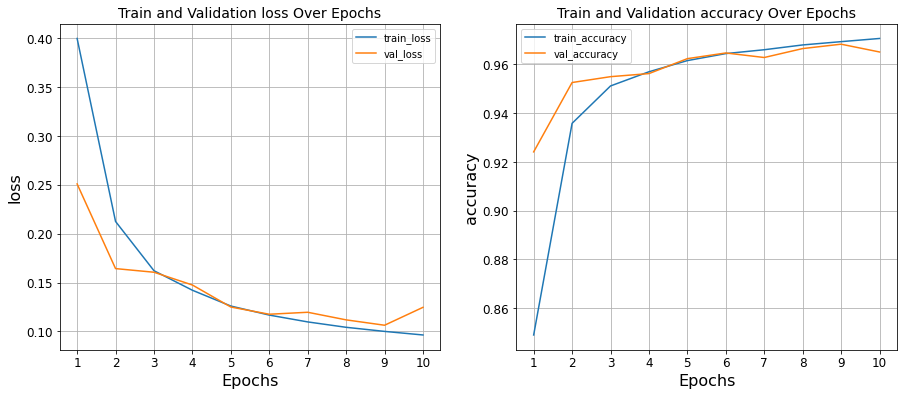

In [41]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_2.history["loss"], label="train_loss")
plt.plot(history_2.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_2.history["accuracy"], label="train_accuracy")
plt.plot(history_2.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_bilstm_wo_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_bilstm_wo_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [42]:
model2.evaluate(X_test, y_test)

469/469 [==============================] - 7s 15ms/step - loss: 0.1236 - accuracy: 0.9630


[0.12363653630018234, 0.9629999995231628]

In [43]:
y_pred_2 = model2.predict(X_test)

In [44]:
y_pred_2 = (y_pred_2 > 0.5)

In [45]:
print(classification_report(y_test,y_pred_2))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4969
           1       0.96      0.96      0.96      5002
           2       0.99      0.95      0.97      5029

   micro avg       0.96      0.96      0.96     15000
   macro avg       0.96      0.96      0.96     15000
weighted avg       0.96      0.96      0.96     15000
 samples avg       0.96      0.96      0.96     15000



C:\Users\tschi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### With glove embeddings

In [46]:
model2 = Sequential()
model2.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
model2.add(layers.Bidirectional(layers.LSTM(10,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()
#plot_model(model2, to_file='/content/drive/MyDrive/dataset_patent/figures/dl_model2_w_anno_400.png', show_shapes=True, show_layer_names=True, dpi=400)
#plot_model(model2, to_file='/content/drive/MyDrive/dataset_patent/figures/dl_model2_w_anno_50.png', show_shapes=True, show_layer_names=True, dpi=50)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 512, 100)          9186700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20)                8880      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 63        
Total params: 9,195,643
Trainable params: 8,943
Non-trainable params: 9,186,700
_________________________________________________________________


In [47]:
history_2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=10)

Epoch 1/10
3750/3750 [==============================] - 140s 37ms/step - loss: 0.6402 - accuracy: 0.7306 - val_loss: 0.5347 - val_accuracy: 0.7999: 57s  - ETA: 51s - loss: 0.7266 - accura - ETA: 51s - loss: 0.7256 - accur - ETA: 50s - loss: 0.7239 - ac - ETA: 49s - loss: 0.7215 - acc - ETA: 48s  - ETA: 43s - loss: 0.7100 - acc - ETA: 42s - loss - ETA: 40s - loss: 0.705 - ETA: 39s - - ETA - ETA: 0s - loss: 0.6406 - accuracy
Epoch 2/10
3750/3750 [==============================] - 137s 37ms/step - loss: 0.3742 - accuracy: 0.8641 - val_loss: 0.2514 - val_accuracy: 0.9137A: 57s - loss: 0.4031 - a - ETA: 56s - lo - ETA: 54s - loss: 0.4015 - accuracy: 0 - ETA: 42s - loss: 0.3968 - ac - ETA: 41s - loss: 0.3965 - accur - ETA: 40s - loss: 0.3961 - ac - ETA: 39s - loss: 0.3956 - accurac - ETA: 38s - loss: 0.3954 - accuracy - ETA: 38s - loss: 0.3951 - accur - ETA: 37s -  - ETA: 35s - l - ETA: 27s - ETA: 24s - loss: 0.3878 - accuracy: 0. - ETA: 24s - loss: 0.387 - ETA: 23s - loss: 0.3874 - accuracy

3750/3750 [==============================] - 132s 35ms/step - loss: 0.1792 - accuracy: 0.9369 - val_loss: 0.1394 - val_accuracy: 0.9536los - ETA: 1:56 - loss: 0 - ETA: 1:55 - loss: 0.1816  - ETA: 1:54 - loss: 0.1818 - accuracy: 0.93 - ETA: 1:54 - loss: 0.1830 - ac - ETA: 1:54 - ETA: 1:44 - loss: 0.1866 - accu - ETA: 1:44 - ETA: 1:41 - loss: 0.1835 -  - ETA: 1:36 - los - ETA: 1:36 - loss: 0.1823 -  - ETA: 1:35 - loss: 0.1816  - ETA: 1:34 - loss: 0.181 - ETA: 1:34 - loss: 0.181 - ETA - ET - ETA: 59s - loss: 0.1792 - ETA: 58s - loss: 0.1791 - accuracy: 0 - ETA: 58s - loss: 0.1790 - accura - ETA: 57s - loss: 0.1790 - accuracy:  - ETA: 57s - loss: 0.1790 - ETA: 55s - loss: 0.1786 - ac - ETA: 54s -  - ETA: 52s - loss: 0.1784 - accuracy: 0.9 - ETA: 52s - loss: 0.1782 - accuracy: 0.93 - ETA: 52s - loss: 0.1784 - accuracy: 0.9 - ETA: 52s - loss: 0.1787 - accuracy: 0 - ETA: 51s - loss: 0.1789 - ETA: 5 - ETA: 48s - loss: 0.1789 - accuracy: 0. - ETA: 47s - loss: 0.179 - ETA: 46s - loss: 0.17 - ETA

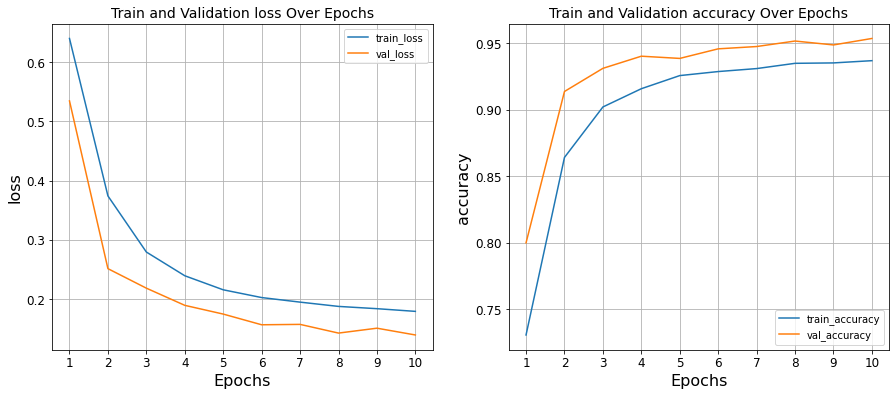

In [48]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_2.history["loss"], label="train_loss")
plt.plot(history_2.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_2.history["accuracy"], label="train_accuracy")
plt.plot(history_2.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_bilstm_w_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_bilstm_w_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [49]:
model2.evaluate(X_test, y_test)

469/469 [==============================] - 8s 16ms/step - loss: 0.1390 - accuracy: 0.9537


[0.138952374458313, 0.9536666870117188]

In [50]:
y_pred_2 = model2.predict(X_test)

In [51]:
y_pred_2 = (y_pred_2 > 0.5)

In [52]:
print(classification_report(y_test,y_pred_2))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      4969
           1       0.98      0.92      0.95      5002
           2       0.95      0.97      0.96      5029

   micro avg       0.96      0.95      0.95     15000
   macro avg       0.96      0.95      0.95     15000
weighted avg       0.96      0.95      0.95     15000
 samples avg       0.95      0.95      0.95     15000



C:\Users\tschi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Sequential 1d-CNN

#### without glove embedding

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 512, 100)          9186700   
_________________________________________________________________
conv1d (Conv1D)              (None, 507, 20)           12020     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 101, 20)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 20)            2420      
_________________________________________________________________
global_max_pooling1d (Global (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 63        
Total params: 9,201,203
Trainable params: 9,201,203
Non-trainable params: 0
____________________________________________

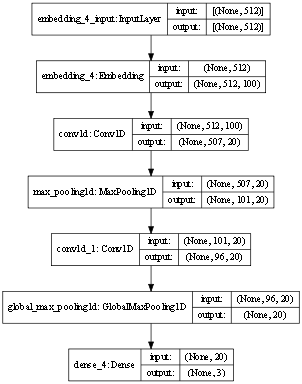

In [53]:
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(len(word_index)+1, 100, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()
# checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
# history = model3.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint3])
plot_model(model3, to_file='dl_model_cnn_wo_annoo_400.png', show_shapes=True, show_layer_names=True, dpi=400)
plot_model(model3, to_file='dl_model_cnn_wo_anno_50.png', show_shapes=True, show_layer_names=True, dpi=50)

In [54]:
history_3 = model3.fit(X_train, y_train, validation_data=(X_val,y_val), verbose=1, epochs=10)

Epoch 1/10
3750/3750 [==============================] - 38s 9ms/step - loss: 0.4993 - accuracy: 0.8625 - val_loss: 0.3222 - val_accuracy: 0.9289
Epoch 2/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.2963 - accuracy: 0.9338 - val_loss: 0.2858 - val_accuracy: 0.9354
Epoch 3/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.2644 - accuracy: 0.9406 - val_loss: 0.2565 - val_accuracy: 0.9439s - loss: 0.2644 - accuracy: 0.
Epoch 4/10
3750/3750 [==============================] - 32s 9ms/step - loss: 0.2471 - accuracy: 0.9454 - val_loss: 0.2487 - val_accuracy: 0.9445
Epoch 5/10
3750/3750 [==============================] - 32s 9ms/step - loss: 0.2342 - accuracy: 0.9484 - val_loss: 0.2329 - val_accuracy: 0.9487
Epoch 6/10
3750/3750 [==============================] - 32s 9ms/step - loss: 0.2252 - accuracy: 0.9504 - val_loss: 0.2237 - val_accuracy: 0.9507
Epoch 7/10
3750/3750 [==============================] - 32s 9ms/step - loss: 0.2184 - accuracy: 0.9

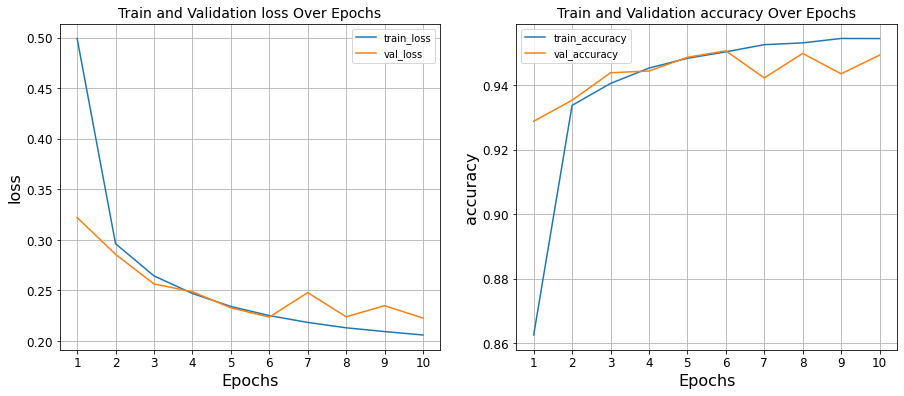

In [55]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_3.history["loss"], label="train_loss")
plt.plot(history_3.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_3.history["accuracy"], label="train_accuracy")
plt.plot(history_3.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_cnn_wo_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_cnn_wo_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [56]:
# history_3.history

In [57]:
model3.evaluate(X_test, y_test)

469/469 [==============================] - 2s 3ms/step - loss: 0.2201 - accuracy: 0.9485


[0.22010202705860138, 0.9485333561897278]

In [58]:
y_pred_3 = model3.predict(X_test)

In [59]:
y_pred_3 = (y_pred_3 > 0.5)

In [60]:
print(classification_report(y_test, y_pred_3))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4969
           1       0.95      0.94      0.94      5002
           2       0.97      0.93      0.95      5029

   micro avg       0.95      0.94      0.95     15000
   macro avg       0.95      0.94      0.95     15000
weighted avg       0.95      0.94      0.95     15000
 samples avg       0.94      0.94      0.94     15000



C:\Users\tschi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### with glove embedding

In [61]:
from keras import regularizers
model3 = Sequential()
model3.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()
# checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
# history = model3.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint3])
#plot_model(model3, to_file='/content/drive/MyDrive/dataset_patent/figures/dl_model3_w_anno_400.png', show_shapes=True, show_layer_names=True, dpi=400)
#plot_model(model3, to_file='/content/drive/MyDrive/dataset_patent/figures/dl_model3_w_anno_50.png', show_shapes=True, show_layer_names=True, dpi=50)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 512, 100)          9186700   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 507, 20)           12020     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 101, 20)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 96, 20)            2420      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 63        
Total params: 9,201,203
Trainable params: 14,503
Non-trainable params: 9,186,700
_______________________________________

In [62]:
history_3 = model3.fit(X_train, y_train, validation_data=(X_val,y_val), verbose=1, epochs=10)

Epoch 1/10
3750/3750 [==============================] - 25s 7ms/step - loss: 0.6779 - accuracy: 0.8743 - val_loss: 0.4326 - val_accuracy: 0.9158
Epoch 2/10
3750/3750 [==============================] - 27s 7ms/step - loss: 0.4295 - accuracy: 0.9117 - val_loss: 0.3889 - val_accuracy: 0.9265
Epoch 3/10
3750/3750 [==============================] - 25s 7ms/step - loss: 0.4054 - accuracy: 0.9172 - val_loss: 0.3772 - val_accuracy: 0.9275
Epoch 4/10
3750/3750 [==============================] - 28s 7ms/step - loss: 0.3943 - accuracy: 0.9190 - val_loss: 0.4765 - val_accuracy: 0.8871
Epoch 5/10
3750/3750 [==============================] - 28s 7ms/step - loss: 0.3852 - accuracy: 0.9201 - val_loss: 0.4234 - val_accuracy: 0.8975
Epoch 6/10
3750/3750 [==============================] - 28s 7ms/step - loss: 0.3802 - accuracy: 0.9208 - val_loss: 0.3542 - val_accuracy: 0.9299
Epoch 7/10
3750/3750 [==============================] - 27s 7ms/step - loss: 0.3770 - accuracy: 0.9216 - val_loss: 0.3591 - val_ac

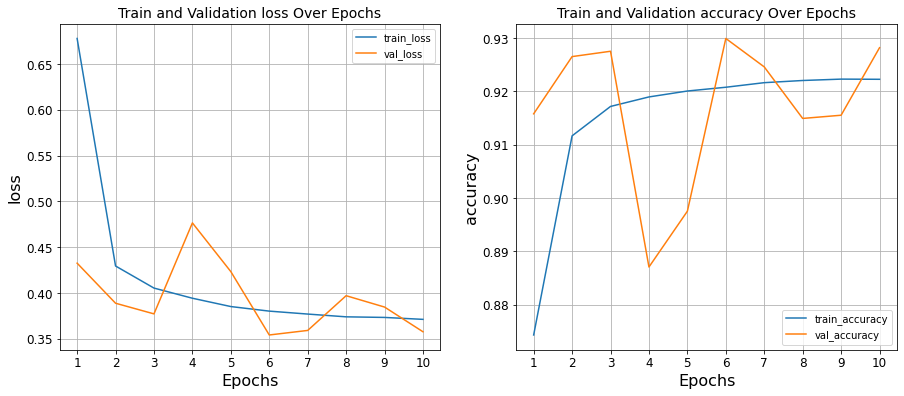

In [63]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_3.history["loss"], label="train_loss")
plt.plot(history_3.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_3.history["accuracy"], label="train_accuracy")
plt.plot(history_3.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_cnn_w_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_cnn_w_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [64]:
# history_3.history

In [65]:
model3.evaluate(X_test, y_test)

469/469 [==============================] - 2s 3ms/step - loss: 0.3541 - accuracy: 0.9298


[0.35411548614501953, 0.9297999739646912]

In [66]:
y_pred_3 = model3.predict(X_test)

In [67]:
y_pred_3 = (y_pred_3 > 0.5)

In [68]:
print(classification_report(y_test, y_pred_3))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      4969
           1       0.95      0.89      0.92      5002
           2       0.97      0.92      0.94      5029

   micro avg       0.94      0.92      0.93     15000
   macro avg       0.94      0.92      0.93     15000
weighted avg       0.94      0.92      0.93     15000
 samples avg       0.92      0.92      0.92     15000



C:\Users\tschi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Sequential model GRU

#### Without glove embedding

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 512, 100)          9186700   
_________________________________________________________________
gru (GRU)                    (None, 20)                7320      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 63        
Total params: 9,194,083
Trainable params: 9,194,083
Non-trainable params: 0
_________________________________________________________________


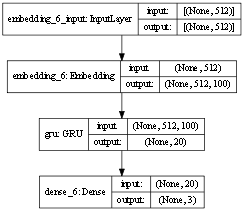

In [69]:
model4 = Sequential()
model4.add(layers.Embedding(len(word_index)+1, 100, input_length=max_len))
model4.add(layers.GRU(20,dropout=0.6, activation='relu'))
model4.add(layers.Dense(3,activation='softmax'))
model4.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()
plot_model(model4, to_file='dl_model_gru_wo_anno_400.png', show_shapes=True, show_layer_names=True, dpi=400)
plot_model(model4, to_file='dl_model_gru_wo_anno_wo_50.png', show_shapes=True, show_layer_names=True, dpi=50)

In [70]:
history_4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=10)

Epoch 1/10
3750/3750 [==============================] - 4838s 1s/step - loss: 0.3119 - accuracy: 0.8775 - val_loss: 0.1258 - val_accuracy: 0.9585
Epoch 2/10
3750/3750 [==============================] - 4548s 1s/step - loss: 0.1229 - accuracy: 0.9603 - val_loss: 0.1072 - val_accuracy: 0.9664
Epoch 3/10
3750/3750 [==============================] - 4655s 1s/step - loss: 0.1113 - accuracy: 0.9649 - val_loss: 0.1068 - val_accuracy: 0.9677
Epoch 4/10
3750/3750 [==============================] - 4754s 1s/step - loss: 0.1060 - accuracy: 0.9669 - val_loss: 0.1067 - val_accuracy: 0.9687
Epoch 5/10
3750/3750 [==============================] - 4613s 1s/step - loss: 0.1033 - accuracy: 0.9678 - val_loss: 0.1035 - val_accuracy: 0.9691
Epoch 6/10
3750/3750 [==============================] - 4632s 1s/step - loss: 0.1008 - accuracy: 0.9695 - val_loss: 0.0983 - val_accuracy: 0.9714
Epoch 7/10
3750/3750 [==============================] - 4130s 1s/step - loss: 0.0997 - accuracy: 0.9697 - val_loss: 0.0985 -

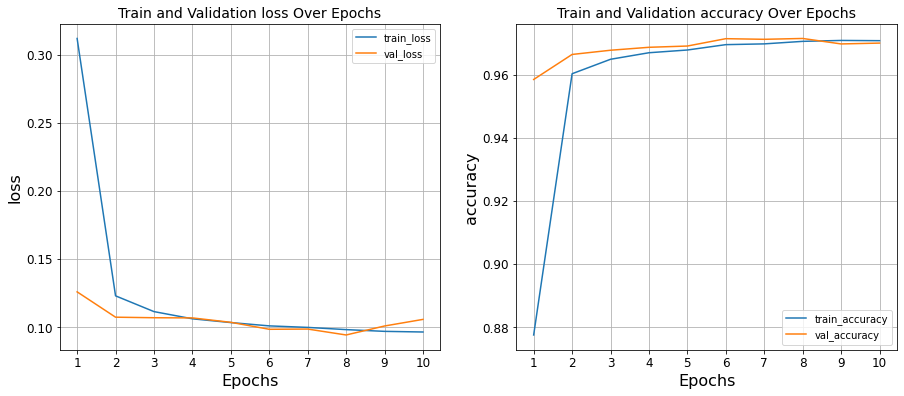

In [71]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_4.history["loss"], label="train_loss")
plt.plot(history_4.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_4.history["accuracy"], label="train_accuracy")
plt.plot(history_4.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_gru_wo_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_gru_wo_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [72]:
model4.evaluate(X_test, y_test)

469/469 [==============================] - 134s 285ms/step - loss: 0.1011 - accuracy: 0.9713


[0.10113752633333206, 0.9713333249092102]

In [73]:
y_pred_4 = model4.predict(X_test)

In [74]:
y_pred_4 = (y_pred_4 > 0.5)

In [75]:
print(classification_report(y_test,y_pred_4))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4969
           1       0.97      0.96      0.97      5002
           2       0.98      0.97      0.98      5029

   micro avg       0.97      0.97      0.97     15000
   macro avg       0.97      0.97      0.97     15000
weighted avg       0.97      0.97      0.97     15000
 samples avg       0.97      0.97      0.97     15000



C:\Users\tschi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### With glove embedding

In [76]:
model4 = Sequential()
model4.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
model4.add(layers.GRU(20,dropout=0.6, activation='relu'))
model4.add(layers.Dense(3,activation='softmax'))
model4.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()
#plot_model(model4, to_file='/content/drive/MyDrive/dataset_patent/figures/dl_model4_anno_w_400.png', show_shapes=True, show_layer_names=True, dpi=400)
#plot_model(model4, to_file='/content/drive/MyDrive/dataset_patent/figures/dl_model4_anno_w_50.png', show_shapes=True, show_layer_names=True, dpi=50)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 512, 100)          9186700   
_________________________________________________________________
gru_1 (GRU)                  (None, 20)                7320      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 63        
Total params: 9,194,083
Trainable params: 7,383
Non-trainable params: 9,186,700
_________________________________________________________________


In [77]:
history_4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=10)

Epoch 1/10
3750/3750 [==============================] - 3383s 902ms/step - loss: 0.5280 - accuracy: 0.7693 - val_loss: 0.2443 - val_accuracy: 0.9130
Epoch 2/10
3750/3750 [==============================] - 4972s 1s/step - loss: 0.2512 - accuracy: 0.9108 - val_loss: 0.1655 - val_accuracy: 0.9410
Epoch 3/10
3750/3750 [==============================] - 4932s 1s/step - loss: 0.2129 - accuracy: 0.9257 - val_loss: 0.1538 - val_accuracy: 0.9463
Epoch 4/10
3750/3750 [==============================] - 4712s 1s/step - loss: 0.1951 - accuracy: 0.9317 - val_loss: 0.1456 - val_accuracy: 0.9496
Epoch 5/10
3750/3750 [==============================] - 4716s 1s/step - loss: 0.1830 - accuracy: 0.9359 - val_loss: 0.1338 - val_accuracy: 0.9545
Epoch 6/10
3750/3750 [==============================] - 5019s 1s/step - loss: 0.1769 - accuracy: 0.9391 - val_loss: 0.1275 - val_accuracy: 0.9557
Epoch 7/10
3750/3750 [==============================] - 4798s 1s/step - loss: 0.1741 - accuracy: 0.9397 - val_loss: 0.128

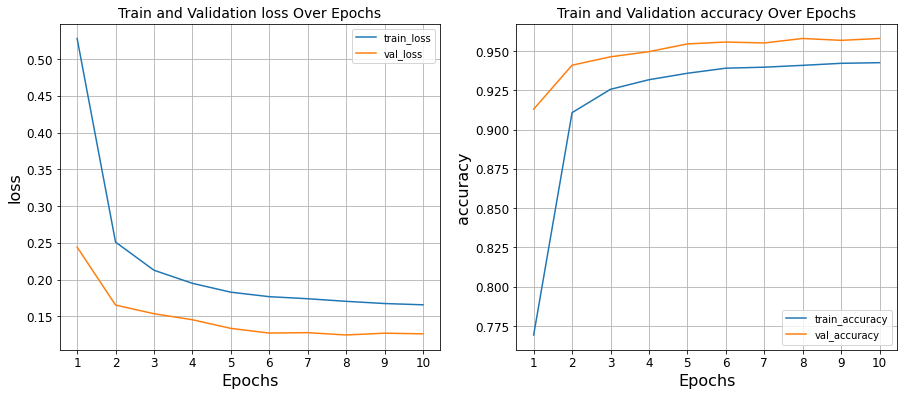

In [78]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1) 
plt.plot(history_4.history["loss"], label="train_loss")
plt.plot(history_4.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
# plt.show()
plt.subplot(1, 2, 2) 
plt.plot(history_4.history["accuracy"], label="train_accuracy")
plt.plot(history_4.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.xticks(np.arange(a), np.arange(1, a+1), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Train and Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('model_4_gru_loss_50', dpi=50,  bbox_inches='tight', transparent=True, pad_inches=0)
plt.savefig('model_4_gru_loss_400', dpi=400,  bbox_inches='tight', transparent=True, pad_inches=0)

plt.show()

In [79]:
model4.evaluate(X_test, y_test)

469/469 [==============================] - 134s 285ms/step - loss: 0.1271 - accuracy: 0.9583


[0.12711307406425476, 0.9583333134651184]

In [80]:
y_pred_4 = model4.predict(X_test)

In [81]:
y_pred_4 = (y_pred_4 > 0.5)

In [82]:
print(classification_report(y_test,y_pred_4))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      4969
           1       0.97      0.93      0.95      5002
           2       0.98      0.95      0.97      5029

   micro avg       0.96      0.96      0.96     15000
   macro avg       0.96      0.96      0.96     15000
weighted avg       0.96      0.96      0.96     15000
 samples avg       0.96      0.96      0.96     15000



C:\Users\tschi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Further Evaluation and Graphs

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

In [ ]:
predictions = model1.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})